In [ ]:
# !unzip drive/MyDrive/IST707/ASL_Dataset001.zip -d drive/MyDrive/IST707

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
sns.set_style('darkgrid')

In [ ]:
os.getcwd()

'/content'

In [ ]:
base_dir = "drive/MyDrive/IST707/Project/"
target_dir = base_dir + "ASL_Dataset"

dF_file = "procesed_data_w_imgdata.csv"
dataset_path = base_dir + dF_file

In [ ]:
data_dir = pathlib.Path(target_dir)
print('Training images:', len(list(data_dir.glob('*/*.*'))))

Training images: 61214


In [ ]:
folders = ["Models", "callback_checkpoints"]
for folder in folders:
    if not os.path.exists(base_dir + folder):
        os.makedirs(base_dir + folder)

In [ ]:
# df = pd.read_csv(base_dir + "procesed_data_w_imgdata.csv", index_col= 0)

In [ ]:
# df.head()

In [ ]:
# def split_train_test(df):
#     train_df, test_temp = train_test_split(df, train_size=0.80, random_state=0)
#     test_df, valid_df = train_test_split(test_temp, train_size=0.5, random_state=0)
#     return train_df, test_df, valid_df

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

In [ ]:
# Set up image generators for the training, validation, and test sets
img_width, img_height = 128, 128
batch_size = 64
num_classes = 39
train_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical', subset='validation')
test_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 48973 images belonging to 39 classes.
Found 12241 images belonging to 39 classes.
Found 61214 images belonging to 39 classes.


In [ ]:
# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
train_generator.num_classes

39

In [ ]:
# Add new classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Summarizing the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']       

In [ ]:
# Define callbacks for the model
checkpoint = ModelCheckpoint(base_dir + 'callback_checkpoints/resnet50v2_2.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001)

callback = [checkpoint, earlystop, reduce_lr]

In [ ]:
# Train the model using a training dataset and validate using a validation dataset
history = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=callback)

Epoch 1/5
766/766 [==============================] - 12680s 17s/step - loss: 0.2855 - accuracy: 0.9169 - val_loss: 0.3620 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/5
766/766 [==============================] - 381s 498ms/step - loss: 0.1118 - accuracy: 0.9649 - val_loss: 0.4454 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 3/5
766/766 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9722
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
766/766 [==============================] - 376s 491ms/step - loss: 0.0861 - accuracy: 0.9722 - val_loss: 0.7496 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 4/5
766/766 [==============================] - 377s 492ms/step - loss: 0.0288 - accuracy: 0.9905 - val_loss: 0.3764 - val_accuracy: 0.9114 - lr: 2.0000e-04


In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

957/957 [==============================] - 373s 389ms/step - loss: 0.0974 - accuracy: 0.9758
Test accuracy: 0.9758225083351135


In [ ]:
# Saving the model
model.save(base_dir + 'Models/resnet50v2_imagenet_1_V1.h5')

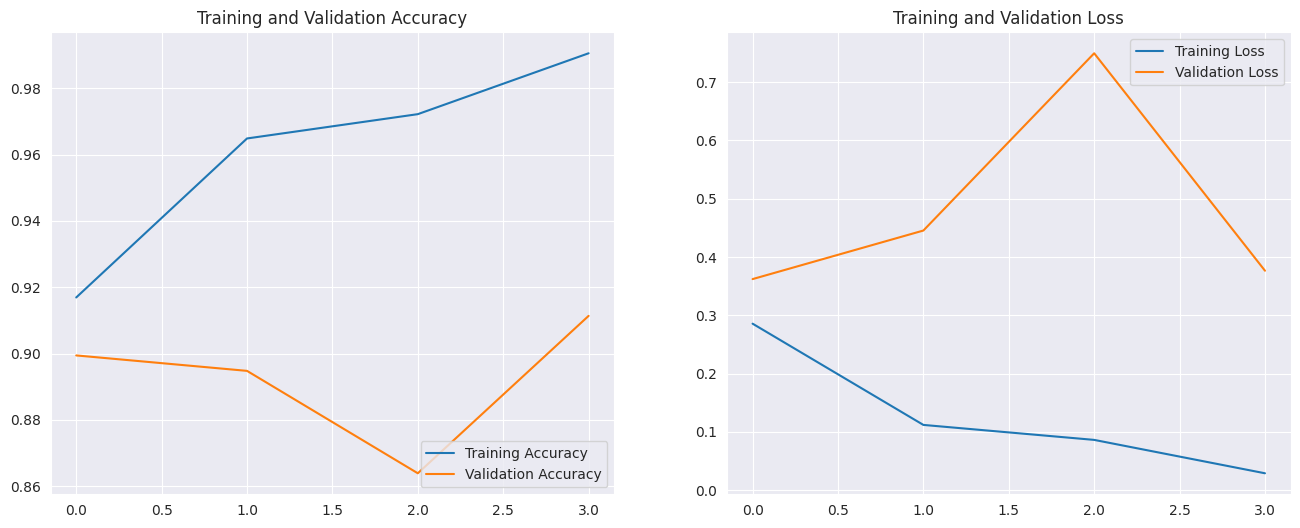

In [ ]:
# Visualization
# Plotting the accuracies and losses
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluate the model using a test generator
test_loss, test_acc = model.evaluate_generator(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Generate predictions on the test generator
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Calculate the classification report
report = classification_report(y_true, y_pred)
print('Classification Report:')
print(report)

<ipython-input-38-0ee64cc7d096>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator)


Test loss: 0.09576895833015442
Test accuracy: 0.9761002659797668


<ipython-input-38-0ee64cc7d096>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


Confusion Matrix:
[[1567    0    0 ...    0    0    0]
 [   0 1563    1 ...    0    0    2]
 [   0    0 1558 ...    0    0    0]
 ...
 [   0    0    0 ... 1496    0    1]
 [   0    0    0 ...    0 1555    5]
 [   0    5    0 ...    1   13 1387]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1570
           1       0.99      1.00      0.99      1570
           2       0.98      0.99      0.99      1570
           3       0.99      1.00      1.00      1570
           4       0.99      0.99      0.99      1570
           5       1.00      1.00      1.00      1570
           6       0.99      0.98      0.98      1570
           7       0.99      0.99      0.99      1570
           8       1.00      1.00      1.00      1570
           9       1.00      0.99      0.99      1570
          10       0.94      0.99      0.96      1563
          11       0.94      0.99      0.97      1570
          12       0.96     

In [ ]:
# y_prob = model.predict_proba(test_generator)

In [ ]:
# y_prob

In [ ]:
y_true

array([ 0,  0,  0, ..., 38, 38, 38], dtype=int32)

In [ ]:
test_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'del': 14,
 'e': 15,
 'f': 16,
 'g': 17,
 'h': 18,
 'i': 19,
 'j': 20,
 'k': 21,
 'l': 22,
 'm': 23,
 'n': 24,
 'nothing': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 'space': 31,
 't': 32,
 'u': 33,
 'v': 34,
 'w': 35,
 'x': 36,
 'y': 37,
 'z': 38}

In [ ]:
import json
new_dict = {value: key for key, value in test_generator.class_indices.items()}
with open(base_dir+"labels_index.json", "w") as outfile:
    # write the dictionary to the file as JSON
    json.dump(test_generator.class_indices, outfile)

with open(base_dir+"index_labels.json", "w") as outfile:
    # write the dictionary to the file as JSON
    json.dump(new_dict, outfile)